In [31]:

import importlib
import data_prep as dp
import macro_utils
import pandas as pd
importlib.reload(dp)
importlib.reload(macro_utils)
print(dir(dp))  # Check if functions appear now
import matplotlib.pyplot as plt

Device set to use mps:0


['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'calculate_sentiment', 'calculate_sentiment_stats', 'datetime', 'download_vix_data', 'load_data', 'load_macro_df', 'macro_analysis', 'merge_dataframes', 'micro_analysis', 'np', 'pd', 'pipe', 'pipeline', 're', 'sort_by_date', 'tqdm', 'yf']


In [3]:
#optional
#df = dp.macro_analysis('./../clean_macro_5y_news_1kcap.csv', 'description', 'title')

In [2]:
df = pd.read_csv('./../data/Sentiment Macro 7Y News 2.5K Cap.csv')

In [3]:
df.index = pd.to_datetime(df['date'])

In [4]:
import statsmodels.api as sm
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

df = macro_utils.calculate_stats(df)
df.head()



,Unnamed: 0,date,summary_mean,summary_min,summary_max,summary_pos_count,summary_neg_count,headline_mean,headline_min,headline_max,...,overall_pos_count,overall_neg_count,vix_target,mean_sentiment_decay,shock_pos,shock_neg,sentiment_dominance,dominance_trigger,vix_7d_pct,vix_zscore
date,,,,,,,,,,,,,,,,,,,,,
2017-08-13,29,2017-08-13,0.091027,0.091027,0.091027,1,0,0.092476,0.092476,0.092476,...,2,0,12.33,0.060276,0.091751,0.091751,1,0,0.179904,0.565134
2017-08-18,30,2017-08-18,0.091053,0.091053,0.091053,1,0,0.086394,0.086394,0.086394,...,2,0,14.26,0.091751,0.088724,0.088724,1,0,0.403543,1.606260
2017-08-19,31,2017-08-19,0.081515,0.081515,0.081515,1,0,0.081813,0.081813,0.081813,...,2,0,13.19,0.088724,0.081664,0.081664,1,0,0.332323,1.192475
2017-08-29,32,2017-08-29,-0.289383,-0.648128,0.069362,1,1,-0.271747,-0.618465,0.074970,...,2,2,11.70,0.081664,0.072166,-0.633296,0,0,0.057866,0.384139
2017-08-31,33,2017-08-31,0.873115,0.873115,0.873115,1,0,0.082140,0.082140,0.082140,...,2,0,10.59,-0.280565,0.477627,0.477627,1,0,-0.052773,-0.283813


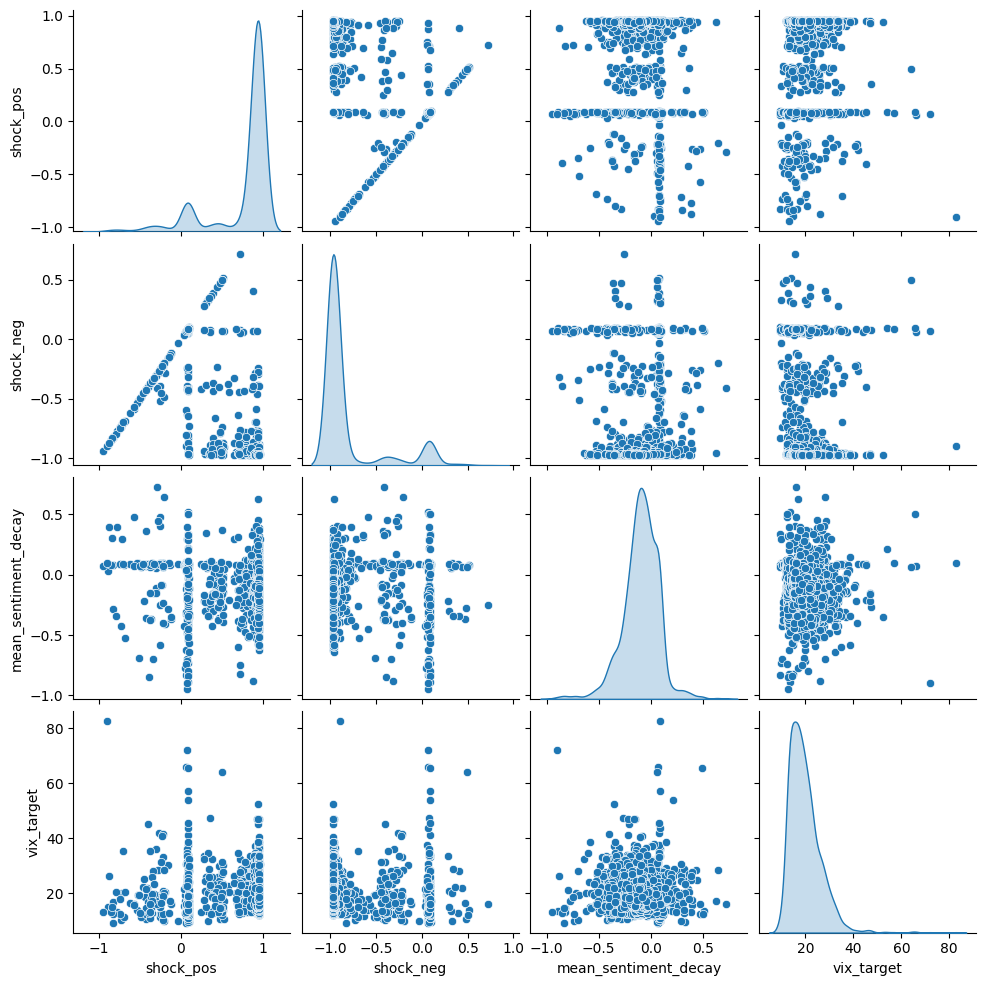

In [5]:
import seaborn as sns
sns.pairplot(df, vars=['shock_pos', 'shock_neg', 'mean_sentiment_decay', 'vix_target'], diag_kind='kde')


In [6]:
feature_sets = [ #for testing, winner was the first one, decreasing in quality for this model sequentially
    ['shock_neg', 'dominance_trigger'],
    ['shock_neg', 'sentiment_dominance'],
    ['shock_neg', 'sentiment_dominance', 'overall_min'],
    ['shock_pos', 'shock_neg', 'sentiment_dominance', 'overall_min'],
    ['shock_pos', 'shock_neg', 'mean_sentiment_decay', 'overall_min', 'sentiment_dominance']
]
selected_features = feature_sets[0]

In [7]:

df.index = pd.to_datetime(df.index)

# Train: Post-COVID to end of 2023
train_df = df[(df.index >= "2020-06-01") & (df.index <= "2023-12-31")]
# Test: Recent years
test_df = df[df.index >= "2024-01-01"]
print(f"Train set: {len(train_df)} rows")
print(f"Test set: {len(test_df)} rows")

df_model = train_df.dropna(subset=feature_sets[0] + ['vix_target']).copy() #i chose first set.
X = df_model[feature_sets[0]]
y = df_model['vix_target']


Train set: 1204 rows
Test set: 458 rows


In [8]:
transition_matrix, results, df_model = macro_utils.regime_t_markov_model(X, y, df_model)

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


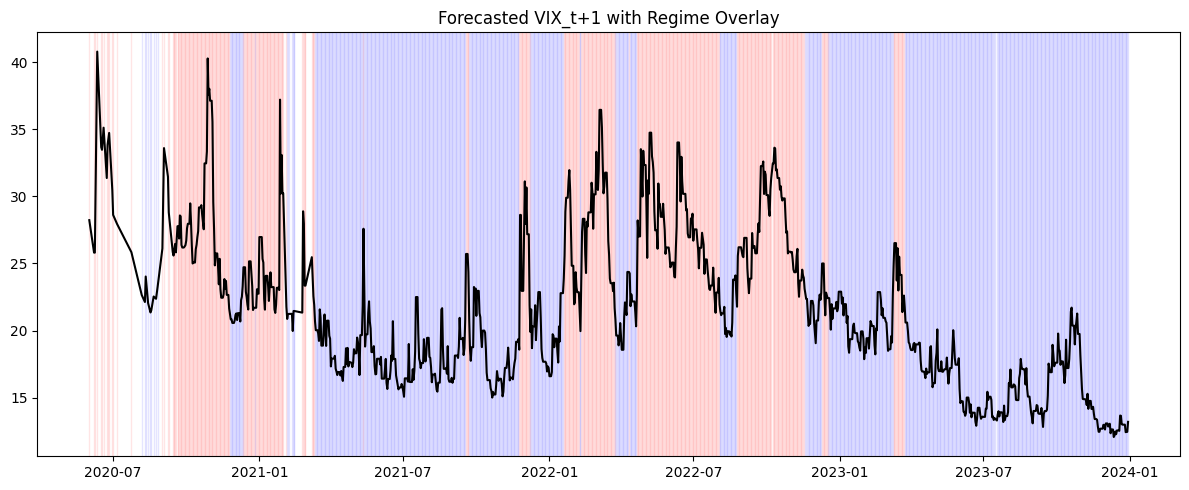

In [9]:
import matplotlib.pyplot as plt #graph vix t+1 with regime overlay

plt.figure(figsize=(12, 5))
plt.plot(df_model.index, df_model['vix_target'], label='VIX_t', color='black')

for i in range(len(df_model)):
    color = 'red' if df_model['regime_t+1'].iloc[i] == 1 else 'blue'
    plt.axvspan(df_model.index[i], df_model.index[i], color=color, alpha=0.1)

plt.title('Forecasted VIX_t+1 with Regime Overlay')
plt.tight_layout()
plt.show()


In [10]:
clf, y_pred, classification_df = macro_utils.clf_panic_tomorrow(df_model, selected_features, 'regime_t+1')

              precision    recall  f1-score   support

         0.0       0.69      0.99      0.81       761
         1.0       0.92      0.22      0.35       442

    accuracy                           0.71      1203
   macro avg       0.80      0.60      0.58      1203
weighted avg       0.77      0.71      0.64      1203



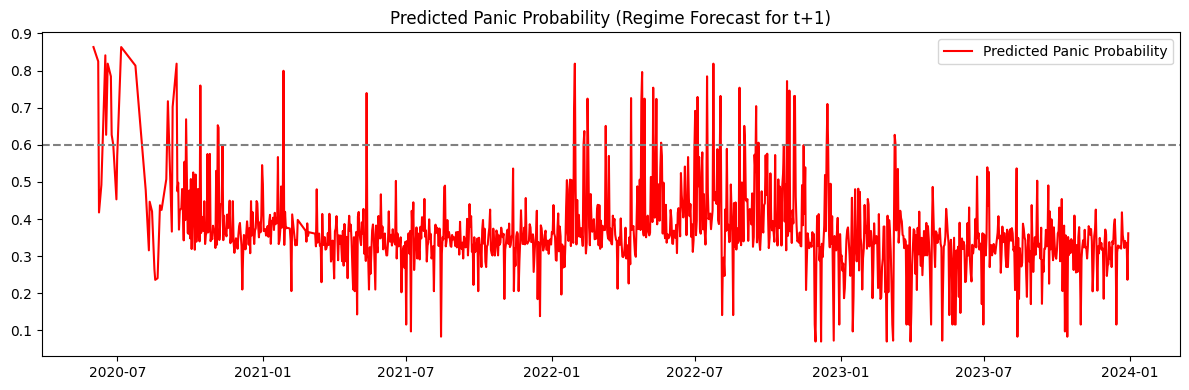

In [11]:
plt.figure(figsize=(12, 4))
plt.plot(df_model.index, df_model['panic_prob'], label='Predicted Panic Probability', color='red')
plt.axhline(0.6, linestyle='--', color='gray')
plt.title("Predicted Panic Probability (Regime Forecast for t+1)")
plt.legend()
plt.tight_layout()
plt.show()


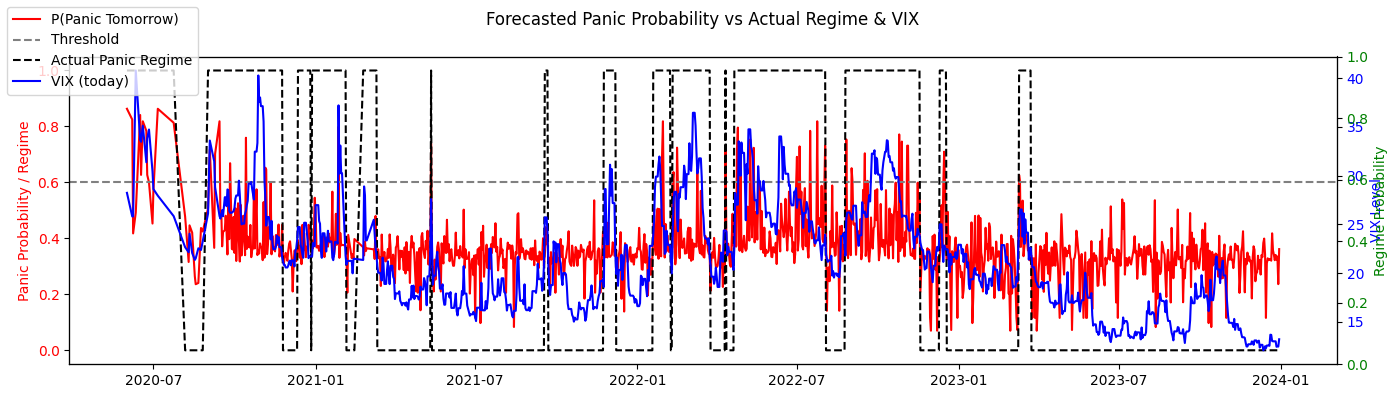

In [13]:
fig, ax1 = plt.subplots(figsize=(14, 4)) #GOLD. panic regime probability goes up before vix even spikes. probability of panic tomorrow from classifier is high.

# Panic probability
ax1.plot(classification_df.index, classification_df['panic_prob'], label='P(Panic Tomorrow)', color='red')
ax1.axhline(0.6, linestyle='--', color='gray', label='Threshold')
ax1.plot(classification_df.index, classification_df['regime_t+1'], linestyle='--', color='black', label='Actual Panic Regime')
ax1.set_ylabel("Panic Probability / Regime", color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Add second y-axis for VIX
ax2 = ax1.twinx()
ax2.plot(classification_df.index, classification_df['vix_target'], label='VIX (today)', color='blue')
ax2.set_ylabel("VIX Level", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax3 = ax1.twinx()
#ax3.plot(classification_df.index, classification_df['regime_t_raw'], label='Regime Probability', color='green')
ax3.set_ylabel("Regime Probability", color='green')
ax3.tick_params(axis='y', labelcolor='green')

fig.suptitle("Forecasted Panic Probability vs Actual Regime & VIX")
fig.tight_layout()
fig.legend(loc='upper left')
plt.show()
import matplotlib.dates as mdates
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()


for each regime=1, we now get the set of days aferwards to see how vix behaves as soon as the model changes regime

In [14]:

# Train dataset (classification_df)
classification_df = macro_utils.identify_sustained_regimes_and_transitions(classification_df)

# Now you can apply it to the test data (test_df) in the same way:




In [15]:

# Usage Example:
result = macro_utils.transform_vix_data(classification_df, window=60)
vix_windows_df_train = result["vix_windows_df_train"]
regime_windows_df_train = result["regime_windows_df_train"]
vix_windows_past_df_train = result["vix_windows_past_df_train"]


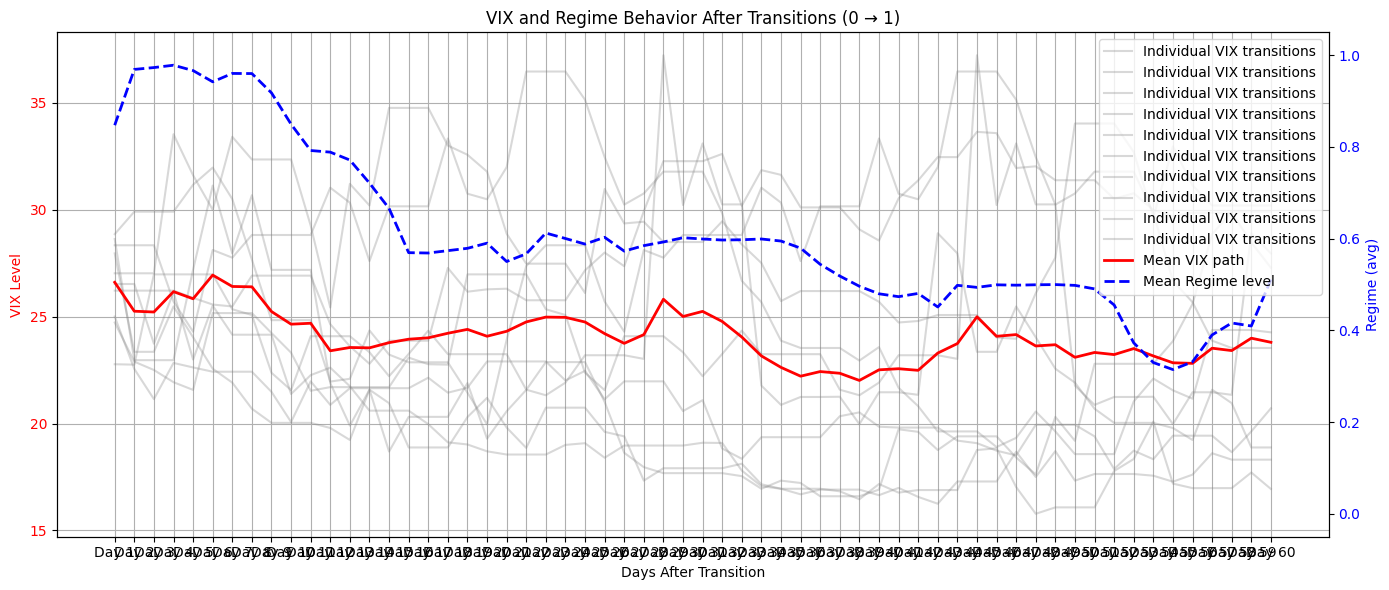

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Primary axis: VIX transitions
ax1 = plt.gca()
ax1.plot(vix_windows_df_train.T, color="gray", alpha=0.3, label="Individual VIX transitions")
ax1.plot(vix_windows_df_train.mean(axis=0).values, color="red", linewidth=2, label="Mean VIX path")
ax1.set_xlabel("Days After Transition")
ax1.set_ylabel("VIX Level", color="red")
ax1.tick_params(axis='y', labelcolor="red")
ax1.set_title("VIX and Regime Behavior After Transitions (0 → 1)")
ax1.grid(True)

# Secondary axis: Regime values
ax2 = ax1.twinx()
ax2.plot(regime_windows_df_train.mean(axis=0).values, color="blue", linewidth=2, linestyle="--", label="Mean Regime level")
ax2.set_ylabel("Regime (avg)", color="blue")
ax2.tick_params(axis='y', labelcolor="blue")
ax2.set_ylim(-0.05, 1.05)  # Because regime is binary

# Combined legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")

plt.tight_layout()
plt.show()



since some spikes happen quite some time after the regime switches, we will build a classifier for 0 (immediate) or 1 (delayed), then feed this into a model for vix level forecasting

In [19]:
df_delayed_spike_prob = macro_utils.clf_delayed_spike_prob(vix_windows_df_train, df_model, "vix_target")

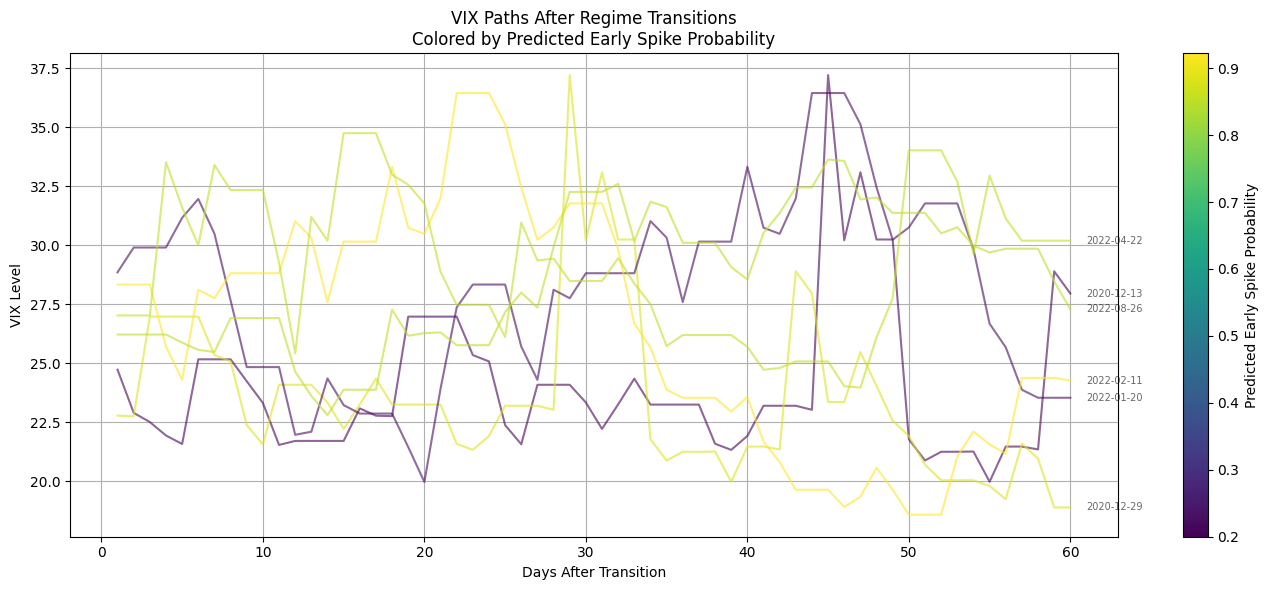

In [20]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Filter rows with predictions
df_plot = df_delayed_spike_prob.dropna(subset=["early_spike_prob"])

# Normalize probs for coloring
probs = df_plot["early_spike_prob"]
colors = cm.viridis((probs - probs.min()) / (probs.max() - probs.min()))

fig, ax = plt.subplots(figsize=(14, 6))

# Plot VIX paths, colored by classifier probability
for i, (date, row) in enumerate(df_plot.iterrows()):
    vix_path = row.iloc[:60]  # assumes 60-day VIX columns are first
    ax.plot(range(1, 61), vix_path.values, color=colors[i], alpha=0.6)
    ax.text(61, vix_path.values[-1], date.strftime("%Y-%m-%d"), fontsize=7, alpha=0.6, va="center")

# Add colorbar
sm = ScalarMappable(cmap="viridis", norm=Normalize(vmin=probs.min(), vmax=probs.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Predicted Early Spike Probability")

# Labels and layout
ax.set_title("VIX Paths After Regime Transitions\nColored by Predicted Early Spike Probability")
ax.set_xlabel("Days After Transition")
ax.set_ylabel("VIX Level")
ax.grid(True)
plt.tight_layout()
plt.show()



In [32]:
model_long, model_sharp, y_pred_long, y_pred_sharp, sharp_rises_X, long_rises_X, sharp_rises_y, long_rises_y = macro_utils.linear_reg_models(vix_windows_df_train)

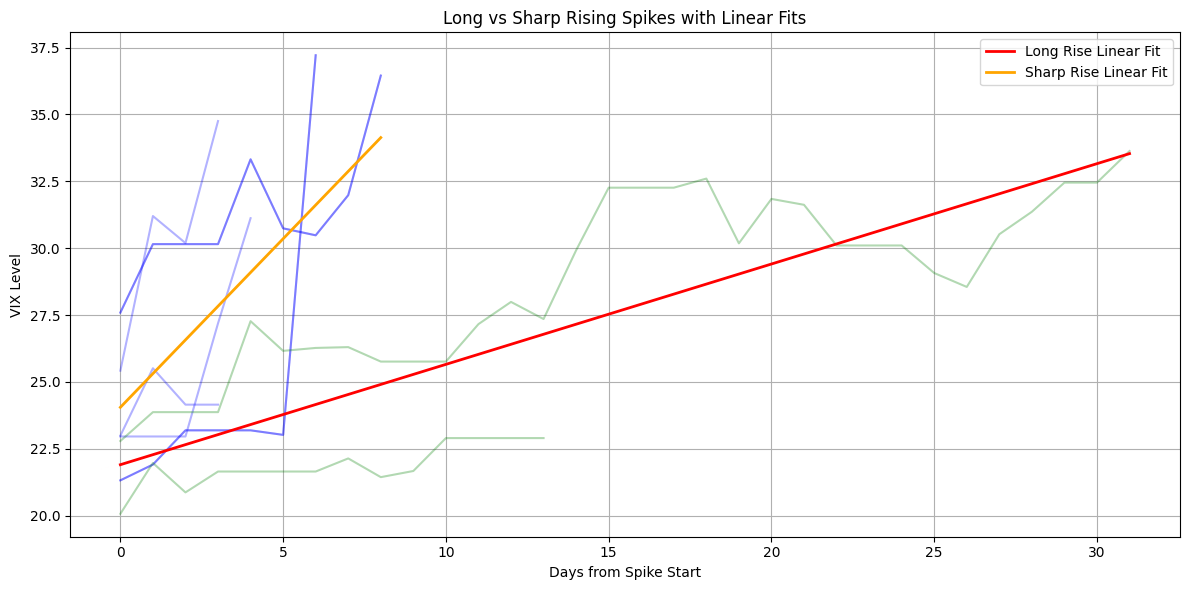

In [33]:
plt.figure(figsize=(12, 6))

# Plot sharp rises (blue)
for i in range(len(sharp_rises_X)):
    plt.plot(sharp_rises_X[i], sharp_rises_y[i], alpha=0.3, color='blue')

# Plot long rises (green)
for i in range(len(long_rises_X)):
    plt.plot(long_rises_X[i], long_rises_y[i], alpha=0.3, color='green')

# Plot long rise regression (red)
plt.plot(np.sort(long_rises_X_combined.flatten()), 
         model_long.predict(np.sort(long_rises_X_combined, axis=0)), 
         color='red', linewidth=2, label='Long Rise Linear Fit')

# Plot sharp rise regression (orange)
plt.plot(np.sort(sharp_rises_X_combined.flatten()), 
         model_sharp.predict(np.sort(sharp_rises_X_combined, axis=0)), 
         color='orange', linewidth=2, label='Sharp Rise Linear Fit')

plt.title("Long vs Sharp Rising Spikes with Linear Fits")
plt.xlabel("Days from Spike Start")
plt.ylabel("VIX Level")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# now we fit an NN

# Test Set on models (regime + panic probability)


In [ ]:
vix_windows_df_train

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 51,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60
transition_time,,,,,,,,,,,,,,,,,,,,,
2020-09-03,31.459999,28.809999,25.850000,25.590000,26.040001,26.459999,25.830000,27.780001,27.780001,26.860001,...,37.130001,35.549999,29.570000,27.580000,24.860001,25.750000,25.750000,25.750000,24.799999,23.450001
2020-12-13,24.719999,22.889999,22.500000,21.930000,21.570000,25.160000,25.160000,25.160000,24.230000,23.309999,...,20.870001,21.240000,21.240000,21.250000,19.969999,21.459999,21.459999,21.340000,28.889999,27.950001
2020-12-29,22.770000,22.750000,26.969999,26.969999,26.969999,26.969999,25.340000,25.070000,22.370001,21.559999,...,20.690001,20.030001,20.030001,20.030001,19.790001,19.230000,21.580000,20.950001,18.879999,18.879999
2021-02-25,27.950001,23.350000,23.350000,25.469999,24.030001,22.559999,21.910000,20.690001,20.030001,20.030001,...,17.639999,17.639999,17.639999,17.559999,17.280001,17.610001,18.610001,18.309999,18.309999,18.309999
2021-11-25,28.620001,22.959999,22.959999,22.959999,27.190001,31.120001,27.950001,30.670000,27.180000,27.180000,...,22.790001,22.790001,22.790001,22.790001,23.850000,25.590000,28.850000,29.900000,29.900000,29.900000
2022-01-20,28.850000,29.900000,29.900000,29.900000,31.160000,31.959999,30.490000,27.660000,24.830000,24.830000,...,31.770000,31.770000,31.770000,29.830000,26.670000,25.670000,23.870001,23.530001,23.530001,23.530001
2022-02-11,28.330000,28.330000,28.330000,25.700001,24.290001,28.110001,27.750000,28.809999,28.809999,28.809999,...,18.570000,18.570000,21.030001,22.100000,21.549999,21.160000,24.370001,24.370001,24.370001,24.260000
2022-04-22,27.020000,27.020000,27.020000,33.520000,31.600000,29.990000,33.400002,32.340000,32.340000,32.340000,...,34.020000,34.020000,32.689999,29.620001,32.950001,31.129999,30.190001,30.190001,30.190001,30.190001
2022-08-26,26.209999,26.209999,26.209999,26.209999,25.870001,25.559999,25.469999,26.910000,26.910000,26.910000,...,31.370001,30.500000,30.760000,29.980000,29.690001,29.850000,29.850000,29.850000,28.459999,27.280001


In [692]:
# 1. After fitting on training set
train_params = results.params

# 2. Prepare your test data
test_df['vix_target_t+1'] = test_df['vix_target'].shift(-1)
test_df = test_df.dropna(subset=selected_features + ['vix_target_t+1']).copy()

X_test = test_df[selected_features]
y_test = test_df['vix_target_t+1']



# 3. Define same model on test data
model_test = MarkovRegression(
    endog=y_test,
    exog=X_test,
    k_regimes=2,
    switching_variance=False
)

# 4. Apply training parameters with FILTER (real-time regime inference)
results_test = model_test.filter(train_params)

# 5. Extract real-time regime (filtered) — sensitive threshold
test_df['regime_t'] = results_test.filtered_marginal_probabilities[1].apply(lambda p: 1 if p >= 0.005 else 0)
test_df['regime_t_raw'] = results_test.filtered_marginal_probabilities[1]

# 6. Predict probability of panic regime tomorrow using classifier (NO regime_t)
test_df['panic_prob_t+1'] = clf0.predict_proba(X_test)[:, 1]

# 7. (Optional) Align as prediction for tomorrow
test_df['panic_prob_t+1'] = test_df['panic_prob_t+1'].shift(1)
test_df['vix_target_t+1'] = test_df['vix_target'].shift(-1)




/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


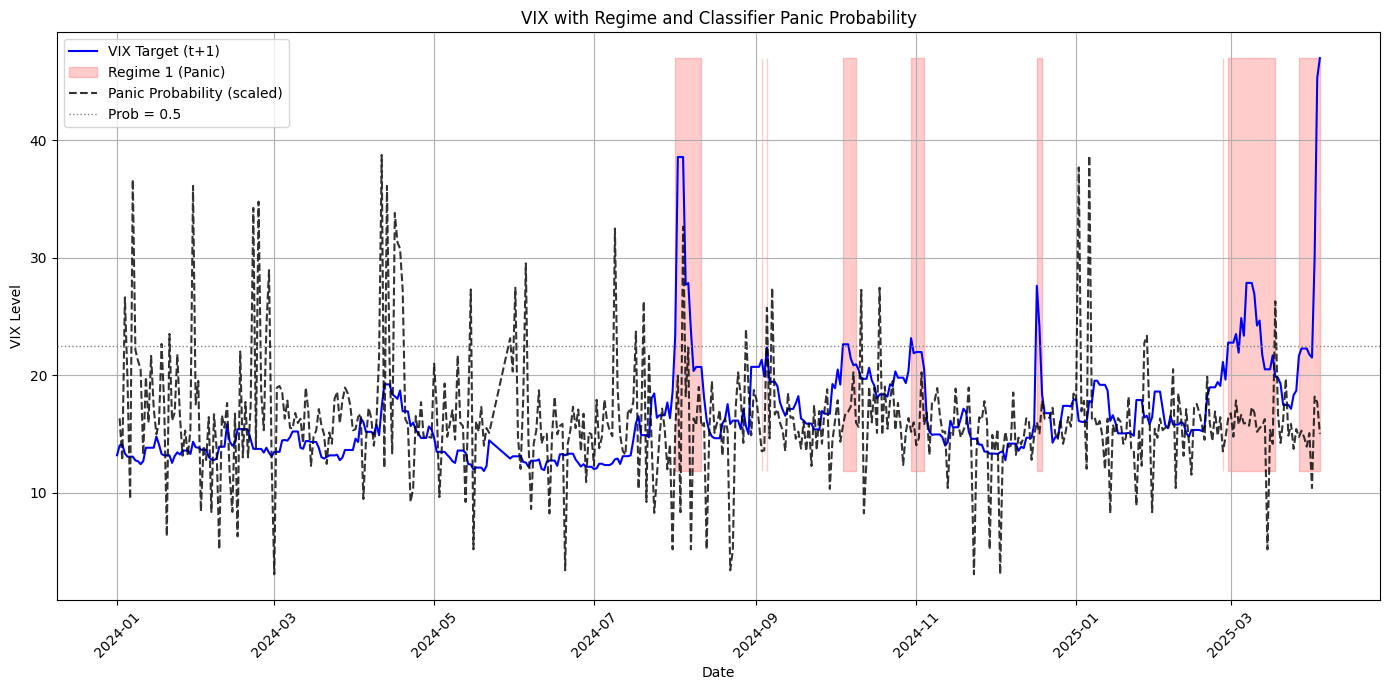

In [646]:
import matplotlib.pyplot as plt

# Assumes test_df already has:
# - 'vix_target_t+1' (VIX values)
# - 'regime_t' (real-time inferred regime: 0 or 1)
# - 'panic_prob_t+1' (classifier probability of panic tomorrow)

plt.figure(figsize=(14, 7))

# 1. Plot VIX
plt.plot(test_df.index, test_df["vix_target_t+1"], label="VIX Target (t+1)", color="blue")

# 2. Shade areas where regime is 1 (panic)
plt.fill_between(
    test_df.index,
    test_df["vix_target_t+1"].min(),
    test_df["vix_target_t+1"].max(),
    where=test_df["regime_t"] == 1,
    color="red",
    alpha=0.2,
    label="Regime 1 (Panic)"
)

# 3. Plot panic probability (scaled for visibility)
scaled_prob = test_df["panic_prob_t+1"] * (test_df["vix_target_t+1"].max() - 2)
plt.plot(test_df.index, scaled_prob, label="Panic Probability (scaled)", color="black", linestyle="--", alpha=0.8)

# Optional: Add threshold line for prob=0.5 scaled to same scale
plt.axhline(y=0.5 * (test_df["vix_target_t+1"].max() - 2), color="gray", linestyle=":", linewidth=1, label="Prob = 0.5")

# Finalize
plt.title("VIX with Regime and Classifier Panic Probability")
plt.xlabel("Date")
plt.ylabel("VIX Level")
plt.legend(loc="upper left")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Markov Switching Auto Regressive model

In [214]:
regime_0_df = df_model[df_model['regime_t'] == 0]
regime_1_df = df_model[df_model['regime_t'] == 1]

In [215]:
from statsmodels.tsa.ar_model import AutoReg

ar_regime_0 = AutoReg(regime_0_df['vix_target'], lags=1, trend='c').fit()
ar_regime_1 = AutoReg(regime_1_df['vix_target'], lags=1, trend='c').fit()

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [216]:
import numpy as np
def forecast_vix_autoreg(current_vix, current_regime):
    phi = ar_regime_0.params if current_regime == 0 else ar_regime_1.params
    forecast = phi['const'] + phi['vix_target.L1'] * current_vix
    return forecast

In [217]:
sigma_0 = np.std(ar_regime_0.resid)
sigma_1 = np.std(ar_regime_1.resid)

phi_0 = ar_regime_0.params
phi_1 = ar_regime_1.params

transition_matrix_forecast = transition_matrix #from our first model

initial_regime = df_model['regime_t'].iloc[-1]  # last predicted regime


In [218]:
first_panic = test_df[test_df['regime_t'] == 1].iloc[0]
print(first_panic['vix_target'])


18.59000015258789


In [219]:
# Step 1: Detect regime transitions (0 → 1)
test_df['regime_t-1'] = test_df['regime_t'].shift(1)
test_df['is_transition'] = (test_df['regime_t-1'] == 0) & (test_df['regime_t'] == 1)



In [220]:
test_df[test_df['is_transition']]

,Unnamed: 0,date,summary_mean,summary_min,summary_max,summary_pos_count,summary_neg_count,headline_mean,headline_min,headline_max,...,shock_neg,sentiment_dominance,dominance_trigger,vix_7d_pct,vix_zscore,vix_target_t+1,regime_t,panic_prob_t+1,regime_t-1,is_transition
date,,,,,,,,,,,,,,,,,,,,,
2024-08-01,1703,2024-08-01,-0.292869,-0.973897,0.947609,65,99,-0.278619,-0.974209,0.950001,...,-0.974053,-34,1,0.283840,1.867475,23.389999,1,0.477831,0.0,True
2024-09-03,1736,2024-09-03,-0.033295,-0.969301,0.948438,106,54,-0.090644,-0.966677,0.939915,...,-0.967989,52,0,0.414334,0.340104,21.320000,1,0.489463,0.0,True
2024-09-05,1738,2024-09-05,-0.127234,-0.968873,0.949641,210,91,-0.040936,-0.975435,0.943705,...,-0.972154,119,0,0.223110,0.550898,22.379999,1,0.514686,0.0,True
2024-10-04,1767,2024-10-04,-0.161758,-0.974880,0.956488,25,24,-0.179731,-0.966917,0.948299,...,-0.970898,1,0,0.176362,0.892619,22.639999,1,0.466187,0.0,True
2024-10-30,1793,2024-10-30,-0.023059,-0.976818,0.955613,42,27,-0.070288,-0.969683,0.952119,...,-0.973251,15,0,-0.014050,0.358336,23.160000,1,0.493824,0.0,True
2024-12-17,1841,2024-12-17,-0.200720,-0.973212,0.951735,128,95,-0.080458,-0.973030,0.951784,...,-0.973121,33,0,0.189655,1.374896,27.620001,1,0.493454,0.0,True
2025-02-28,1914,2025-02-28,-0.178687,-0.975512,0.954631,75,60,-0.157563,-0.966205,0.952781,...,-0.970858,15,0,0.300000,1.494880,22.780001,1,0.475647,0.0,True
2025-03-27,1941,2025-03-27,-0.116046,-0.972738,0.951299,190,97,-0.160304,-0.974677,0.947820,...,-0.973707,93,0,-0.228642,-0.946713,21.650000,1,0.472414,0.0,True


In [221]:
# Step 2: Store 15-day windows of VIX after each transition
window = 5
vix_windows = []

for idx in test_df[test_df['is_transition']].index:
    # Get position of the index
    loc = test_df.index.get_loc(idx)
    # Slice the 15 days following the transition (including the day itself)
    vix_slice = test_df.iloc[loc:loc + window]['vix_target_t+1'].values
    # Only store windows with full length (some at end of data may be shorter)
    if len(vix_slice) == window:
        vix_windows.append(vix_slice)

# Step 3: Convert to DataFrame for analysis/plotting
vix_windows_df = pd.DataFrame(vix_windows)
vix_windows_df.index.name = "Transition #"
vix_windows_df.columns = [f"Day {i}" for i in range(1, window + 1)]

In [222]:
vix_windows_df

,Day 1,Day 2,Day 3,Day 4,Day 5
Transition #,,,,,
0,23.389999,38.570000,38.570000,38.570000,27.709999
1,21.320000,19.900000,22.379999,19.450001,19.450001
2,22.379999,19.450001,19.450001,19.450001,19.080000
3,22.639999,22.639999,22.639999,21.420000,20.860001
4,23.160000,21.879999,21.980000,21.980000,21.980000
5,27.620001,24.090000,18.360001,16.780001,16.780001
6,22.780001,22.780001,22.780001,23.510000,21.930000
7,21.650000,22.280001,22.280001,22.280001,21.770000


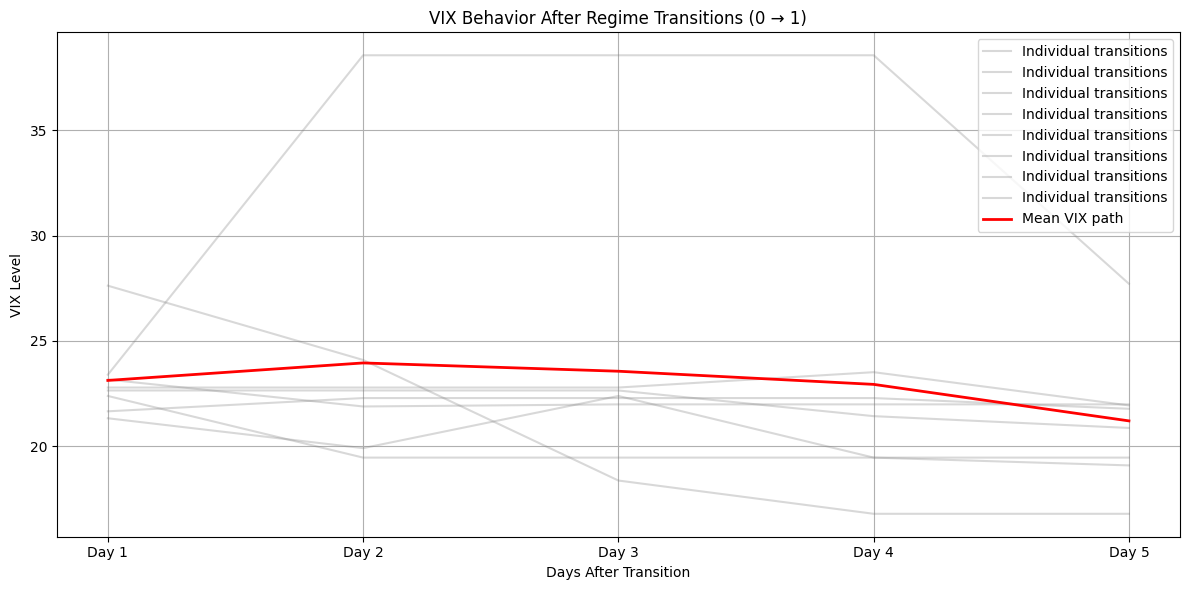

In [223]:
plt.figure(figsize=(12, 6))
plt.plot(vix_windows_df.T, color="gray", alpha=0.3, label="Individual transitions")
plt.plot(vix_windows_df.mean(axis=0).values, color="red", linewidth=2, label="Mean VIX path")

plt.title("VIX Behavior After Regime Transitions (0 → 1)")
plt.xlabel("Days After Transition")
plt.ylabel("VIX Level")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_92478/794786639.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  phi = phi_0[phi_0.index.str.contains('L1')][0]
/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_92478/794786639.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  phi = phi_1[phi_1.index.str.contains('L1')][0]


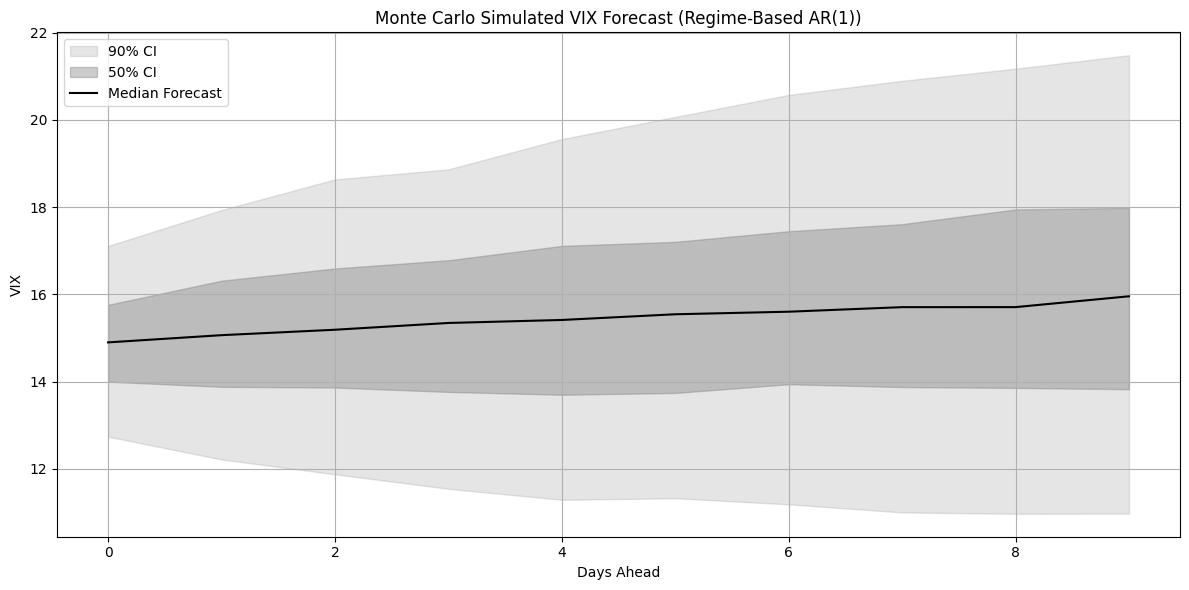

In [39]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_vix_paths_ar(n_days=30, n_paths=1000, start_val=20, start_regime=0,
                          phi_0=None, phi_1=None,
                          sigma_0=1.0, sigma_1=1.0,
                          transition_matrix=None):
    paths = np.zeros((n_paths, n_days))
    regimes = np.zeros((n_paths, n_days), dtype=int)

    for i in range(n_paths):
        vix = start_val
        regime = start_regime

        for t in range(n_days):
            # Transition to next regime
            regime = np.random.choice([0, 1], p=transition_matrix[regime])
            regimes[i, t] = regime

            if regime == 0:
                const = phi_0['const']
                phi = phi_0[phi_0.index.str.contains('L1')][0]
                shock = np.random.normal(0, sigma_0)
                vix = const + phi * vix + shock
            else:
                const = phi_1['const']
                phi = phi_1[phi_1.index.str.contains('L1')][0]
                shock = np.random.normal(0, sigma_1)
                vix = const + phi * vix + shock

            paths[i, t] = vix

    return paths, regimes

# === Run the simulation ===
first_panic = test_df[test_df['regime_t'] == 1].iloc[0]
first_panic = first_panic['vix_target']
#start_vix = test_df['vix_target_t+1'].iloc[0]
sim_paths, sim_regimes = simulate_vix_paths_ar(
    n_days=10,
    n_paths=1000,
    start_val=first_panic,
    start_regime=initial_regime,
    phi_0=phi_0,
    phi_1=phi_1,
    sigma_0=sigma_0,
    sigma_1=sigma_1,
    transition_matrix=transition_matrix_forecast
)

# === Plot fan chart ===
percentiles = np.percentile(sim_paths, [5, 25, 50, 75, 95], axis=0)
days = np.arange(sim_paths.shape[1])

plt.figure(figsize=(12, 6))
plt.fill_between(days, percentiles[0], percentiles[-1], color='gray', alpha=0.2, label='90% CI')
plt.fill_between(days, percentiles[1], percentiles[-2], color='gray', alpha=0.4, label='50% CI')
plt.plot(days, percentiles[2], color='black', label='Median Forecast')
plt.title("Monte Carlo Simulated VIX Forecast (Regime-Based AR(1))")
plt.xlabel("Days Ahead")
plt.ylabel("VIX")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [34]:
forecast_horizon = 30
expected_paths = []

# Loop through each test point where regime == 1
for idx in range(len(test_df) - forecast_horizon):
    row = test_df.iloc[idx]
    if row['regime_t'] == 1:
        vix_start = row['vix_target_t+1']
        regime_start = row['regime_t']

        # Simulate forecasts from this point
        sim_paths, _ = simulate_vix_paths_ar(
            n_days=forecast_horizon,
            n_paths=1000,
            start_val=vix_start,
            start_regime=regime_start,
            phi_0=phi_0,
            phi_1=phi_1,
            sigma_0=sigma_0,
            sigma_1=sigma_1,
            transition_matrix=transition_matrix_forecast
        )

        # Use expected value (mean forecast) — or replace with np.median(...) if preferred
        expected_path = np.mean(sim_paths, axis=0)

        # Align with index
        future_dates = test_df.index[idx:idx + forecast_horizon]
        if len(future_dates) == forecast_horizon:
            expected_paths.append((future_dates, expected_path))

# === Plot ===
plt.figure(figsize=(14, 7))

# Plot actual VIX
plt.plot(test_df.index, test_df["vix_target_t+1"], label="VIX Target (t+1)", color="blue")

# Highlight panic regime areas
plt.fill_between(
    test_df.index,
    test_df["vix_target_t+1"].min(),
    test_df["vix_target_t+1"].max(),
    where=test_df["regime_t"] == 1,
    color="red",
    alpha=0.2,
    label="Regime 1 (Panic)"
)

# Plot scaled panic probability
scaled_prob = test_df["panic_prob_t+1"] * (test_df["vix_target_t+1"].max() - 2)
plt.plot(test_df.index, scaled_prob, label="Panic Probability (scaled)", color="black", linestyle="--", alpha=0.8)
plt.axhline(y=0.5 * (test_df["vix_target_t+1"].max() - 2), color="gray", linestyle=":", linewidth=1, label="Prob = 0.5")

# Plot expected forecast paths (mean or median)
for dates, path in expected_paths:
    plt.plot(dates, path, color="green", alpha=0.7, linewidth=1.8, label="Expected VIX Forecast" if 'Expected VIX Forecast' not in plt.gca().get_legend_handles_labels()[1] else "")

# Finalize
plt.title("Expected VIX Forecasts During Panic Regimes")
plt.xlabel("Date")
plt.ylabel("VIX Level")
plt.legend(loc="upper left")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_92478/1077054220.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  phi = phi_1[phi_1.index.str.contains('L1')][0]
/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_92478/1077054220.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  phi = phi_0[phi_0.index.str.contains('L1')][0]


KeyboardInterrupt: 

# XGboost model

In [26]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error



